# Visualising field using `holoviews`

There are several ways how a field can be visualised, using:

- `matplotlib`
- `k3d`
- `holoviews`
- vtk-based libraries, e.g. `pyvista`

`holoviews` provides interactive two-dimensional plots of fields. Different from the `matplotlib` interface it is not required to first slice the field using `sel` method to obtain a two dimensional field. Instead, a slider is automatically created for the out-of-plane component of the 3d field, for example.

In [1]:
import discretisedfield as df

As an example we study an eliptical cylinder. We initialise the field such that its x and y component describe a vortex-like object (with the vortex core position changing along z direction) and the z component changing (and swapping sign) with the position in z direction. We set `valid="norm"` to automatically hide the cells outside the cylinder in all plots.

In [2]:
mesh = df.Mesh(
    p1=(-20e-9, -10e-9, -5e-9), p2=(20e-9, 10e-9, 5e-9), cell=(1e-9, 1e-9, 1e-9)
)


def value(p):
    x, y, z = p
    return -y + z, x + z, z


def norm(p):
    x, y, _ = p
    if (x / 2) ** 2 + y**2 > 10e-9**2:
        return 0
    else:
        return 1


field = df.Field(mesh, nvdim=3, value=value, norm=norm, valid="norm")

We can create a simple plot by calling `hv`. We have to pass two of the spatial directions out of `x`, `y`, and `z` to the `kdims` variable. We choose the `x` and `y` directions. This defines the plot x and plot y direction. Furthermore, we automatically get a slider to select a value for the remaining out-of-plane direction.

In [3]:
# Note for web users: You should have an active notebook session to interact with the plot
field.hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

If there is only one element in the out-of-plane directon the slider is omitted. Note, that `holoviews` by default picks different colourmaps depending on the type of data (and the symmetries it detects in them). Changing the colourmap is explained below.

In [4]:
field.sel("z").hv(kdims=["x", "y"])

:DynamicMap   []
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

Internally, the field is converted to an `xarray DataArray` and `hvplot` is used to create the plot. The plot consists of two parts, a "scalar" part for the out-of-plane component that is visualised with the colour and an in-plane-component part visualised with arrows. We now discuss how to create and modify these individually and in the end come back to the combined plot.

## Scalar plot

To create a scalar plot we use `hv.scalar`.

In [5]:
field.z.hv.scalar(kdims=["x", "y"], clim=(-1, 1))

:DynamicMap   [z]
   :Image   [x,y]   (field)

In the above example we have extracted a single component for the scalar plot. The `hv` interface additionally allows us to do this interactively with a separate widget.

In [6]:
field.hv.scalar(kdims=["x", "y"])

:DynamicMap   [z,vdims]
   :Image   [x,y]   (field)

To filter out parts of the field we can pass an additional variable `roi`. For this example we plot the field in the xy plane, normal to the z direction and remove all values where the absolute value of the z component of the vector field is smaller than 0.5. We can pass additional keyword arguments that are directly forwarded to `xarray.hvplot`, e.g. `clim` and `cmap`. For all available options please refer to the documentation of [holoviews](https://holoviews.org/).

In [7]:
roi = df.Field(field.mesh, nvdim=1, value=abs(field.z.array) < 0.5)

field.z.hv.scalar(kdims=["x", "y"], roi=roi, clim=(-1, 1), cmap="plasma")

:DynamicMap   [z]
   :Image   [x,y]   (field)

It is possible to reduce the number of points show in the plot with parameter `n`. This functionality is rarely needed for scalar plots, refer to the explanation for vector plots below for more details.

In [8]:
field.hv.scalar(kdims=["x", "y"], n=(10, 10), clim=(-1, 1), cmap="plasma")

:DynamicMap   [z,vdims]
   :Image   [x,y]   (field)

In [9]:
field.hv.scalar(kdims=["x", "y"], clim=(-1, 1), cmap="plasma")

:DynamicMap   [z,vdims]
   :Image   [x,y]   (field)

## Vector plot

For vector fields we can create a vector plot where the arrows show direction and length of the in-plane-component and the arrow colour for the out-of-plane component.

In [10]:
field.hv.vector(kdims=["x", "y"]).opts(colorbar=True)

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag,color_comp)

To uses a different component of the same field for colouring we can pass the name of that component.

In [11]:
field.hv.vector(kdims=["x", "y"], cdim="y", cmap="plasma")

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag,color_comp)

To disable automatic colouring we can pass `use_color=False`. By default the arrows are then shown in black. We can use a different uniform colour by passing `color`.

In [12]:
field.hv.vector(kdims=["x", "y"], use_color=False, color="blue")

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag)

For vector plots it is sometimes necessary to reduce the number of arrows shown on the plot. This can be accomplished with the parameter `n`. This parameter specifies the number of points show for different dimensions. A tuple with two `int` values can be passed. These are interpreted as the number of points in the two `kdims`. Internally, a very basic re-sampling is performed (without any interpolation). The extreme points are always kept and additional points are chosen equally distributed in between. Note that this might potentially hide features in complicated situations and should be used with care.

In [13]:
field.hv.vector(kdims=["x", "y"], n=(20, 10))

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag,color_comp)

For 3d vector fields we internally assume, that the first field component points in spatial x direction, the second in y direction, and the third in z direction. If we have a 2d vector field (e.g. a projection in some direction) we do no know which vector components correspond to which spatial directions. Therefore, one has to explicitly select components to be plotted in the plot x and plot y directions using `vdims`. Here we take the first two components of our field to create a new 2d vector field.

In [14]:
field_2d = field.x << field.y

To avoid confusions we rename the components:

In [15]:
field_2d.vdims = ["a", "b"]

In [16]:
field_2d

Field(Mesh(Region(pmin=[-2e-08, -1e-08, -5e-09], pmax=[2e-08, 1e-08, 5e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[40, 20, 10]), nvdim=2, vdims: (a, b))

To create a vector plot for a non-three-dimensional field we have to pass `vdims`.

First, we assume that the first component `a` points in x direction and the second `b` in y direction. We pass a list to `vdims`. Furthermore, we disable automatic colouring because it is not supported for 2d vector fields. (If we wouldn't specify `use_color=False` we would see a warning that automatic colouring is not supported and that it is disabled. By explicitly setting `use_color` to `False` we can avoid this warning.)

In [17]:
field_2d.hv.vector(kdims=["x", "y"], vdims=["a", "b"], use_color=False)

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag)

However, if we look along the x axis we only have the `b` component pointing in y direction but no component in the z direction. We pass a `None` value for the spatial z direction. We can pass the `a` component as additional `cdim`.

In [18]:
field_2d.hv.vector(kdims=["y", "z"], vdims=["b", None], cdim="a")

:DynamicMap   [x]
   :VectorField   [y,z]   (angle,mag,color_comp)

If we have a higher-dimensional field, e.g. four we also have to manually specify `vdims`.

In [19]:
field_4d = field << field.z**2
field_4d.vdims = ["a", "b", "c", "d"]
field_4d.hv.vector(kdims=["x", "y"], vdims=["a", "d"], cdim="c")

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag,color_comp)

In a similar way, we can also explicitly select components for 3d vector fields. For example, we could swap our initial x and y components, so that the first vector component (despite being called `x`) points in spatial y direction and the second vector component (called `y`) points in spatial x direction:

In [20]:
field.hv.vector(kdims=["x", "y"], vdims=["y", "x"])

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag,color_comp)

## Contour lines

Contour line plots behave similar to scalar plots. If the passed field is a vector field a widget is create to select one of the field components.

In [21]:
field.hv.contour(kdims=["x", "y"])

:DynamicMap   [z,vdims]
   :Contours   [x,y]   (field)

## Combining multiple plots

In the beginning we have seen that there is a convenience function to quickly plot 3d vector fields that combines scalar and vector plots. We can pass additional dictionaries to `scalar_kw` and `vector_kw` to adjust the different plots. By default vectors are show in black in the combined plot.

In [22]:
field.hv(kdims=["x", "y"], scalar_kw={"clim": (-1, 1), "cmap": "coolwarm"})

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

Combined plots also support re-sampling with the parameter `n` passed to `scalar_kw` or `vector_kw`. Most useful is generally just a re-sampling of the vector part to reduce the arrow density. This can be accomplished by only passing `n` to `vector_kw`. If a dictionary is used to modify slider dimensions the user must take care that the scalar part and vector part of the plot have the same number of points in the slider directions (so the directions **not** specified in `kdims`).

In [23]:
field.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-1, 1), "cmap": "coolwarm"},
    vector_kw={"n": (20, 15)},
)

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

Filtering is automatically done based on `field.valid`. We show this by setting `valid=True`.

In [24]:
field.valid = True
field.hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We revert back to `valid = "norm"` for the rest of this notebook.

In [25]:
field.valid = "norm"

field.hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

For 2d vector fields we have to pass `vdims` to create a vector plot.

In [26]:
field_2d.hv(kdims=["x", "y"], vdims=["a", "b"]).opts(width=300, height=200)

:DynamicMap   [z]
   :VectorField   [x,y]   (angle,mag)

Otherwise we get a scalar plot with a drop-down selection for the field components.

In [27]:
field_2d.hv(kdims=["x", "y"])

:DynamicMap   [z,vdims]
   :Image   [x,y]   (field)

Fields with more than three vector dimensions behave similar.

In [28]:
field_4d.hv(kdims=["x", "y"])

:DynamicMap   [z,vdims]
   :Image   [x,y]   (field)

In [29]:
field_4d.hv(
    kdims=["x", "y"], vdims=["a", "b"], vector_kw={"cdim": "d", "use_color": True}
)

:DynamicMap   [z,vdims]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag,color_comp)

All functions in the `hv` interface return standard `holoviews` objects. We can save the returned values and create arbitrary more complicated layouts. For more advanced features please directly refer to the [holoviews documentation](https://holoviews.org/).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
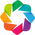

In [30]:
import holoviews as hv

hv.extension("bokeh")
hv.output(widget_location="bottom")

Setting `hv.output` will fail if no plot has been created beforehand. To avoid this run the following set of commands if you want to change the widget location at the top of your notebook:

```python
import holoviews as hv
hv.extension('bokeh')
hv.output(widget_location="bottom")
```

In [31]:
# hide the following warning from bokeh:
# `UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value`
import warnings

warnings.simplefilter("ignore")


scalar_z = field.hv.scalar(
    kdims=["x", "y"], roi=field.norm, clim=(-1, 1), cmap="cividis"
)
contour_z = field.hv.contour(
    kdims=["x", "y"], roi=field.norm, cmap="plasma_r", levels=10, show_legend=False
)

vector_z = field.hv.vector(
    kdims=["y", "z"], cmap="turbo", cdim="x", clim=(-1, 1), use_color=True
)

(scalar_z * contour_z).opts(frame_height=200) + vector_z.opts(frame_height=200)

:Layout
   .DynamicMap.I  :DynamicMap   [z,vdims]
      :Overlay
         .Image.I    :Image   [x,y]   (field)
         .Contours.I :Contours   [x,y]   (field)
   .DynamicMap.II :DynamicMap   [x]
      :VectorField   [y,z]   (angle,mag,color_comp)